# Important Papers

https://www.sciencedirect.com/science/article/pii/S0960077920303246?casa_token=g3PE29gmlPYAAAAA:Me4yIHdPkev1fSpsUuW0CkhVwXr4aH3cUHNkj__WwSZt6XGA1Nmk6wUEDMshkHyOCiLcwYY#sec0002

https://www.jstor.org/stable/4576118?seq=4

https://nzmj.org.nz/media/pages/journal/vol-131-no-1487/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years/ef4958102b-1696475878/new-zealand-s-experience-of-the-1918-19-influenza-pandemic-a-systematic-review-after-100-years.pdf

https://www.sciencedirect.com/science/article/pii/S1755436511000053

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy.optimize import curve_fit
from datetime import datetime
import numpy.typing as npt
from scipy.optimize import minimize
import numpy.typing as npt

In [74]:
#import importlib
import SEIRD_model 
#importlib.reload(SEIRD_model)
import SEIRD_fitting
#importlib.reload(SEIRD_fitting)

<module 'SEIRD_fitting' from '/home/gavin/Documents/NZ_data/SEIRD_fitting.py'>

# Generalized multi-population SEIRD Model 

The number of susceptible $S$, infectious $I$, recovered $R$, and deceased (or non-interacting) $D$ for a given population group $g$ is stored in the Y matrix: $Y^{g}_{c}$, where $g$ is the population (stored in rows), and $c$ is the category ($S^g$, $E^g$, $I^g$, $R^g$ or $D^g$). Thus, in this case $Y$ is an $N$ by 5 matrix, where $N$ is the number of different populations. 

The $\theta$ matrix contains information about how the populations mix. It is an $N$ by $N$ matrix $\theta^i_g$, each element of which has the proportion of population group $g$ that spend that timestep in mixing environment $i$. It can also be thought of as the probability that a person from population $g$ will spend time in mixing environment $m$. $\sum_{m} \theta^m_g = 1$. 

$$ \sum_{g} \theta^m_g ~ Y^{g}_{c} = B^{m}_{c}, $$

where $B^m_c$ is an $M$ by 5 matrix of the number of people in mixing environment $m$ (e.g. young-people env, old folk env) that are of type $c$ (susceptible, exposed, infectious, recovered, or dead). 

The number of new infections in a particular group $g$ depends on their exposure to infectious people while visiting another population's environment, plus the exposure encountered by those who stayed. 

\begin{align}
\text{New Infections for those of type $g$ going to mixing environment }m &= \text{\# susceptible who go} \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
&= S^g\theta^m_g \times \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}}.
\end{align}

Thus, the total number of infections can be calculated:
\begin{align}
\text{New Infections for those in group }g &= \sum_{\text{places visited } m}\text{\# susceptible from $g$ who went to }m \times \beta_m \times \frac{\text{\# infectious in }m}{\text{total \# in }m}, \\
\frac{\text{d}E_g}{\text{d}t} &= Y^g_S \sum_{m} \theta^m_g  \beta_m \times \frac{B^m_{\text{infectious}}}{B^m_{\text{susceptible}} + B^m_{\text{exposed}} + B^m_{\text{infectious}} + B^m_{\text{recovered}}},\\
&=  Y^g_S\sum_{m}\theta^m_g\beta_m \frac{\sum_{g'}\theta^m_{g'} ~ Y^{g'}_{I}}{\sum_{g''}\sum_{c=S,E,I,R} \theta^m_{g''} ~ Y^{g''}_{c}}, \\
\end{align}

A deliberate choice is made here to removed the dead from the population. The logic here is that when folk visit somewhere, they are not mixing with the dead. Thus, dead folk do not reduce the propensity for infection --- they simply are removed from the overall population. However, the number of dead is so small this is probably a small perturbation. 



### Setting the parameters for an example coupled SEIRD model

Creates the `theta_matrix` in a standardised way from an array of arguments 

In [19]:
# The SIRD matrix on the first day of infection
Y_matrix_0 = np.array([[499000, 0, 0, 0, 0],
                       [499000, 0, 100, 0, 0],
                       [160000, 0, 0, 0, 0]])

# The total number of people in each population
N_vector = Y_matrix_0.sum(axis=1)

# the contact rate, beta, for each population
beta_vector = np.array([0.1, 0.3])
# The incubation_rate, recovery rate and death rate
latent_period, gamma, delta = [1.4*np.ones(Y_matrix_0.shape[0]), 
                               0.15, 
                               0.015*np.array([1.,1.,2.])]

# the coupling matrix between the boxes. 
theta_matrix = SEIRD_fitting.fitting_deaths.build_theta_matrix( 0.9, 0.2)

print("Number of populations = {}\n".format(len(beta_vector)))
print(" Starting vector S,E,I,R,D for each population = \n",Y_matrix_0)

print("\nParameters:\n beta_vector = ",beta_vector)
print(" gamma = {},\n delta = {},\n".format(gamma, delta))
print(" latent period = {},\n".format(latent_period))
print(" theta_matrix = \n",theta_matrix)

# the time points (days) over which we want to predict using our model
t = np.linspace(0, 400, 8000)

print("\n\nReady to go!")

Number of populations = 2

 Starting vector S,E,I,R,D for each population = 
 [[499000      0      0      0      0]
 [499000      0    100      0      0]
 [160000      0      0      0      0]]

Parameters:
 beta_vector =  [0.1 0.3]
 gamma = 0.15,
 delta = [0.015 0.015 0.03 ],

 latent period = [1.4 1.4 1.4],

 theta_matrix = 
 [[0.9 0.2 0.9]
 [0.1 0.8 0.1]]


Ready to go!


In [20]:
my_SEIRD = SEIRD_model.SEIRD_model(beta_vector, gamma, delta, latent_period, theta_matrix)

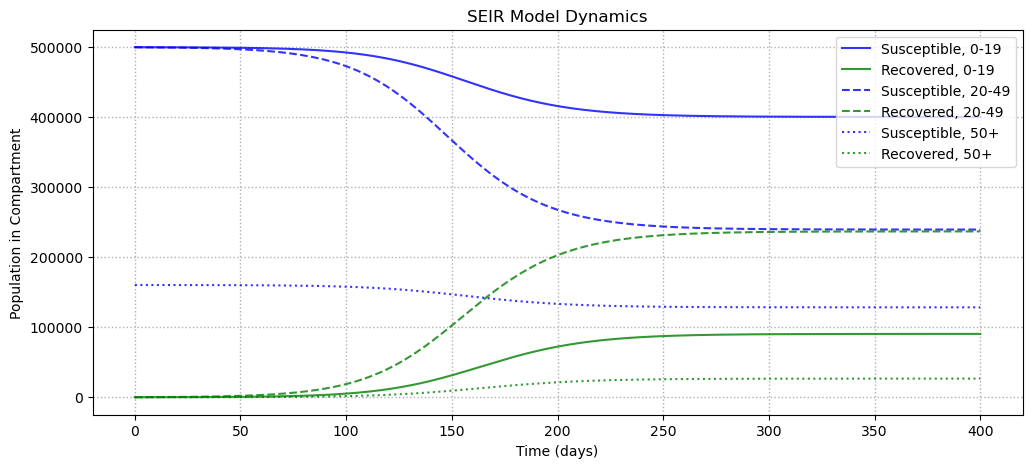

In [21]:
my_SEIRD.plot_Y_t(t,Y_matrix_0, compartments_to_plot=[0,3])

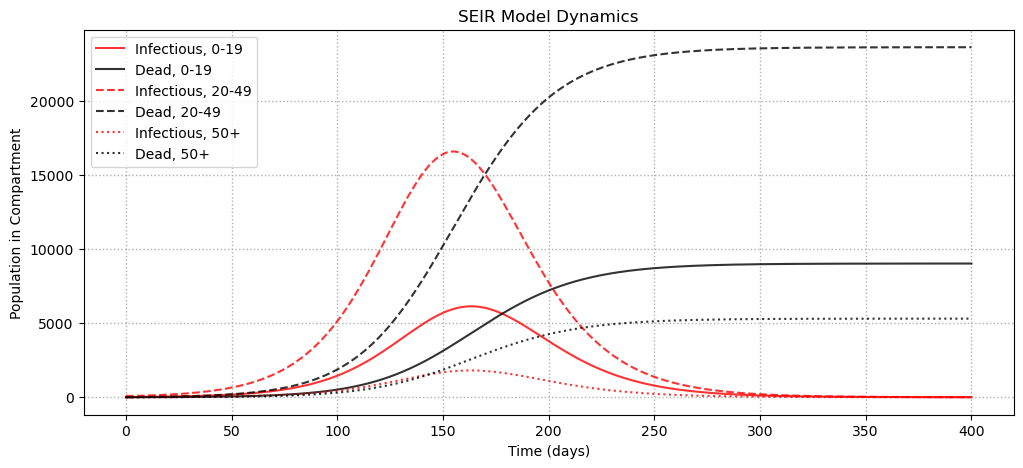

In [22]:
my_SEIRD.plot_Y_t(t,Y_matrix_0, compartments_to_plot=[2,4])

## Observations:

1) It seems that the only way of reducing the overall number of deaths in a category is to reduce the infectiousness $\beta$ for that compartment. If that happens, the overall number of dead in the limit of large $t$ is lower (although there is a larger number of susceptible left at the end).

2) If the coupling $\theta$ is very small, then having different infectivities $\beta$ for each environment is relevant. However, the larger $\theta$ is, the less different $\beta$ values matter. As expected, $\theta = 0$ gives completely decoupled populations, and $\theta = 0.5$ gives perfectly mixed populations. $\theta > 0.5$ has an interesting swapover, where the "old" population spend most of their time in a high$\beta$ environment, and thus actually die more.

3) It ultimately works on the idea that the disease dies out before the entire population is infected due to herd immunity. If the whole population gets infected, then the total number of deaths will be the same in the long run.

4) Theta does not need to be symmetric, i.e. the outcome when $\theta_{yo}$ and $\theta_{oy}$ are switched is not the same. Indeed if $\beta$ is not the same for both populations, then $\theta$ being switched changes the curves significantly. 

### Generating data for fitting

Generate some sparse data with a little noise. This is for fitting tests later.

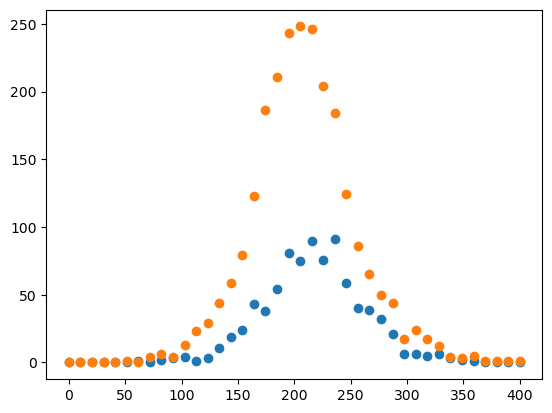

In [23]:
t_sparse = np.linspace(0,400, 40)

deaths_per_day = my_SEIRD.compute_derivs_per_day(t_sparse,
                           50,
                           Y_matrix_0)[:,4,:]

from numpy.random import poisson

shifted_fake_deaths_per_day = poisson(deaths_per_day)
#shifted_fake_deaths_per_day = deaths_per_day

plt.scatter(t_sparse, shifted_fake_deaths_per_day[0], label='Sparse Young Deaths per Day')
plt.scatter(t_sparse, shifted_fake_deaths_per_day[1], label='Sparse Old Deaths per Day')

# 2D version fitting

Going to generate data from the 2D version and fit that. 

Initial guesses for the fit

In [27]:
# Day of the first infection
day_of_start_0 = 48
# The distribution of the population across compartments and groups on the first day of infection.
Y_day_0_of_infection = Y_matrix_0 
# Transmission coefficients for each mixing environment
beta_vector_0 = np.array([0.11, 0.3])
# Recovery rate and death rate
gamma_0 = 0.15
delta_0 = gamma_0*0.1*np.array([1.,1.,2.])
# the coupling matrix between the boxes. 
theta_yo_0 , theta_oy_0 = 0.93 , 0.23
# The mean length of time between exposure and infectiousness
latent_period = latent_period #1.4
# the coupling matrix between the boxes. 
theta_matrix_0 = SEIRD_fitting.fitting_deaths.build_theta_matrix(theta_yo_0, theta_oy_0)

y_data = shifted_fake_deaths_per_day
sigma_y = np.maximum(np.ones(shifted_fake_deaths_per_day.shape), np.sqrt(shifted_fake_deaths_per_day))

bounds = [(30, 70),
          (0.0, 1.0),
          (0.0, 1.0),
          (0.01, 1.0),
#          (0.0001, 0.1),
          (0.0, 1.0),
          (0.0, 1.0)]

print("Initial guesses for the SEIRD model parameters:\n")
print("Day of start of infection = {}\n".format(day_of_start_0))
print(" Starting vector = \n",Y_day_0_of_infection)
print("\nParameters:\n beta_vector = ",beta_vector_0)
print(" gamma = {},\n delta = {},\n".format(gamma_0, delta_0))
print(" latent period = {},\n".format(latent_period))
print(" theta_matrix = \n",theta_matrix_0)

Initial guesses for the SEIRD model parameters:

Day of start of infection = 48

 Starting vector = 
 [[499000      0      0      0      0]
 [499000      0    100      0      0]
 [160000      0      0      0      0]]

Parameters:
 beta_vector =  [0.11 0.3 ]
 gamma = 0.15,
 delta = [0.015 0.015 0.03 ],

 latent period = [1.4 1.4 1.4],

 theta_matrix = 
 [[0.93 0.23 0.93]
 [0.07 0.77 0.07]]


In [28]:
my_model = SEIRD_model.SEIRD_model(beta_vector_0, gamma_0, delta_0, latent_period, theta_matrix_0)

In [29]:
my_fit = SEIRD_fitting.fitting_deaths(t_sparse,
                        y_data,
                        sigma_y=sigma_y,
                        seird_model=my_model,
                        bounds=bounds,
                        Y_0=Y_day_0_of_infection,
                       day_zero=day_of_start_0)

In [30]:
my_fit.fitting_params

[48,
 np.float64(0.11),
 np.float64(0.3),
 0.15,
 np.float64(0.93),
 np.float64(0.23)]

Plot the initial guess

Xi value = 6.617562992475419


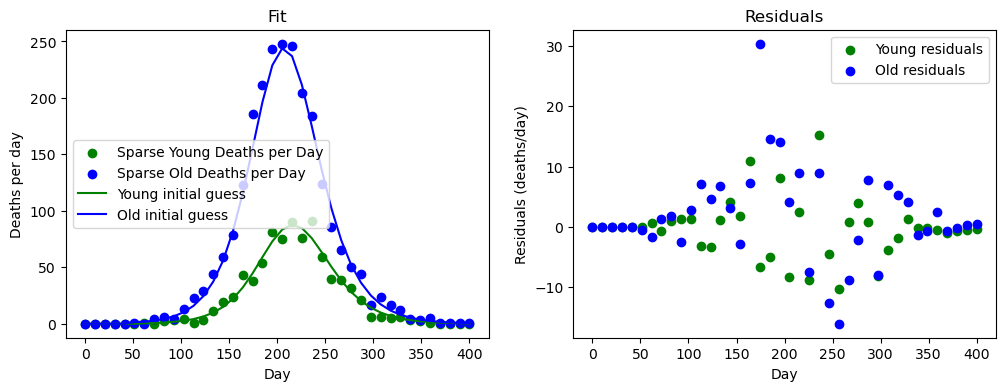

In [31]:
my_fit.plot_fit()

Run the fit

In [32]:
%%time
my_fit.do_minimize()
print(my_fit.opt)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6.013550819676828
             x: [ 5.128e+01  8.362e-02  3.155e-01  1.438e-01  9.178e-01
                  2.692e-01]
           nit: 643
          nfev: 1114
 final_simplex: (array([[ 5.128e+01,  8.362e-02, ...,  9.178e-01,
                         2.692e-01],
                       [ 5.128e+01,  8.362e-02, ...,  9.178e-01,
                         2.692e-01],
                       ...,
                       [ 5.128e+01,  8.362e-02, ...,  9.178e-01,
                         2.692e-01],
                       [ 5.128e+01,  8.362e-02, ...,  9.178e-01,
                         2.692e-01]], shape=(7, 6)), array([ 6.014e+00,  6.014e+00,  6.014e+00,  6.014e+00,
                        6.014e+00,  6.014e+00,  6.014e+00]))
CPU times: user 50.5 s, sys: 14.8 ms, total: 50.5 s
Wall time: 50.7 s


In [33]:
my_fit.fitting_params

array([51.28205128,  0.08361917,  0.31548365,  0.14380176,  0.91784114,
        0.26923025])

Plot after the fit

Xi value = 6.013550819676928


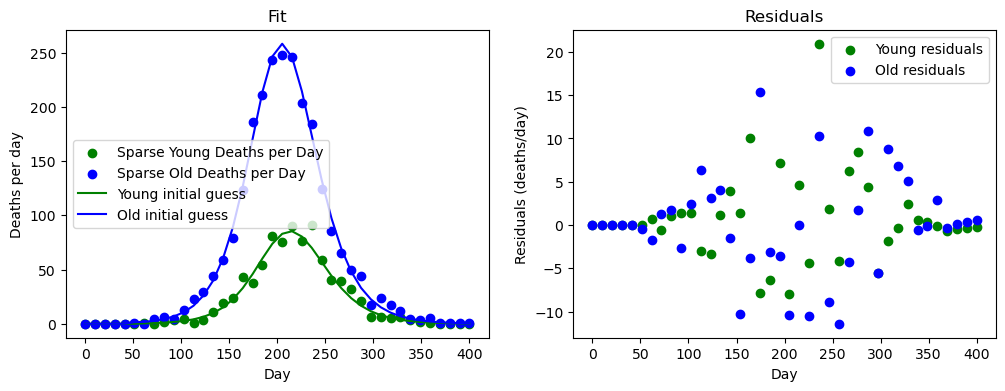

In [34]:
my_fit.plot_fit()

In [36]:
day_of_first_infection_fit, beta_fit_young, beta_fit_old, theta_yo_fit, theta_oy_fit, gamma_fit = my_fit.opt.x
delta_fit = gamma_fit * 0.01 * np.array([1.,1.,2])
print("Final fitted parameters are:")
print("   day zero = {:.2g} ,".format(day_of_first_infection_fit))
print("   beta_y   = {:.3g} ,".format(beta_fit_young))
#print("   beta_m   = {:.3g} ,".format(beta_fit_mid))
print("   beta_o   = {:.3g} ,".format(beta_fit_old))
print("   gamma    = {:.3g} ,".format(gamma_fit)) 
print("   delta    = {:.3g} ,".format(delta_fit[0]))
print("   theta_yo = {:.3g} ,".format(theta_yo_fit))
print("   theta_oy = {:.3g} ,\n".format(theta_oy_fit))

Final fitted parameters are:
   day zero = 51 ,
   beta_y   = 0.0836 ,
   beta_o   = 0.315 ,
   gamma    = 0.269 ,
   delta    = 0.00269 ,
   theta_yo = 0.144 ,
   theta_oy = 0.918 ,



# Training the model

We're going to do it with some ages, and the aim to get the $t \rightarrow \infty$ limit for the number of deaths equal to the total number of deaths of the age ranges and sexes.

But, for starters, we'll just train the simple SIRD model on NZ data. 



In [37]:
NZ_death_data = pd.read_csv('deaths_by_age_and_date.csv').drop(columns=['Unnamed: 0'])
NZ_death_data.loc[:,'Total'] = NZ_death_data.loc[:,'0-19']+NZ_death_data.loc[:,'20-49']+NZ_death_data.loc[:,'50+']
NZ_death_data

date_death military_binary  0-19  20-49  50+  Total
0    1918-09-01 00:00:00               Y     0      1    0      1
1    1918-09-02 00:00:00               Y     0      6    0      6
2    1918-09-03 00:00:00               Y     0      4    0      4
3    1918-09-04 00:00:00               Y     0     23    0     23
4    1918-09-05 00:00:00               Y     1     15    0     16
..                   ...             ...   ...    ...  ...    ...
147  1919-02-22 00:00:00               Y     0      2    0      2
148  1919-02-23 00:00:00               Y     0      1    0      1
149  1919-02-24 00:00:00               Y     0      2    0      2
150  1919-02-25 00:00:00               Y     0      3    0      3
151  1919-02-27 00:00:00               Y     0      1    0      1

[152 rows x 6 columns]

In [38]:
N_0_19 , N_20_49, N_50p =  455502, 481145, 161536  # from age census data 1916
N_T = N_0_19 + N_20_49 + N_50p
print("From NZ census data 1916\n----------------------------\nNumber of 0 - 19:  {} ,\nNumber of 20 - 49: {} ,\nNumber of 50+:     {},\n     Total number :   {}".format(N_0_19, N_20_49, N_50p, N_T))

From NZ census data 1916
----------------------------
Number of 0 - 19:  455502 ,
Number of 20 - 49: 481145 ,
Number of 50+:     161536,
     Total number :   1098183


In [161]:
y_young = NZ_death_data.sort_values('date_death')['0-19']
y_mid   = NZ_death_data.sort_values('date_death')['20-49']
y_old   = NZ_death_data.sort_values('date_death')['50+']

y_data = np.array([y_young, y_mid, y_old])

sigma_data = np.maximum(np.ones(y_data.shape),np.sqrt(y_data))

xplot = pd.to_datetime(NZ_death_data.sort_values('date_death').loc[:,'date_death'])
dummy = xplot
dummymin = min(xplot)
x_data = dummy.apply(lambda l: l - dummymin).dt.days

# Fitting the matrix version

In [216]:
Y_day_0_of_infection = np.array([[455502, 0, 0, 0, 0],
                                 [481145-10, 0, 10, 0, 0],
                                 [161536, 0, 0, 0, 0]])

gamma_0, delta_0 = 0.3, 0.006

beta_vector_0 = [0.3, 0.7]

latent_period = 1.4

theta_yo_0, theta_oy_0 = 0.85, 0.15
theta_matrix_0 = SEIRD_fitting.fitting_deaths.build_theta_matrix( theta_yo_0, theta_oy_0)

day_of_first_infection_0 = 10

bounds=[(0,60),(0.,1.),(0.,2.0),(0.01,1.),(0.,1.),(0.,1.)]

In [207]:
my_model = SEIRD_model.SEIRD_model(beta_vector_0, gamma_0, delta_0, latent_period, theta_matrix_0)

In [208]:
my_fit = SEIRD_fitting.fitting_deaths(x_data,
                        y_data,
                        sigma_y=sigma_data,
                        seird_model=my_model,
                        bounds=bounds,
                        Y_0=Y_day_0_of_infection,
                       day_zero=day_of_first_infection_0)

Xi value = 67.02471525362677


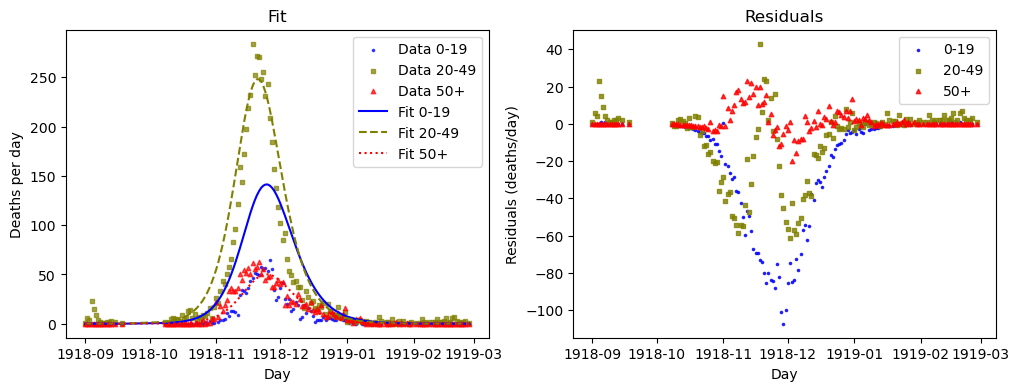

In [209]:
my_fit.plot_fit(labellist=['0-19','20-49','50+'], xplot=xplot)

In [217]:
my_fit.bounds = bounds

In [218]:
%%time
my_fit.do_minimize()
my_fit.opt

CPU times: user 2min 59s, sys: 38.6 ms, total: 2min 59s
Wall time: 3min


       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 20.287122034803662
             x: [ 3.009e+01  4.658e-01  1.716e+00  1.000e+00  8.799e-01
                  0.000e+00]
           nit: 2547
          nfev: 3995
 final_simplex: (array([[ 3.009e+01,  4.658e-01, ...,  8.799e-01,
                         0.000e+00],
                       [ 3.009e+01,  4.658e-01, ...,  8.799e-01,
                         3.822e-16],
                       ...,
                       [ 3.009e+01,  4.658e-01, ...,  8.799e-01,
                         1.405e-16],
                       [ 3.009e+01,  4.658e-01, ...,  8.799e-01,
                         6.164e-16]], shape=(7, 6)), array([ 2.029e+01,  2.029e+01,  2.029e+01,  2.029e+01,
                        2.029e+01,  2.029e+01,  2.029e+01]))

In [219]:
my_fit.fitting_params

array([3.00859811e+01, 4.65837062e-01, 1.71572565e+00, 1.00000000e+00,
       8.79916280e-01, 1.40521479e-16])

Xi value = 20.287122034803684


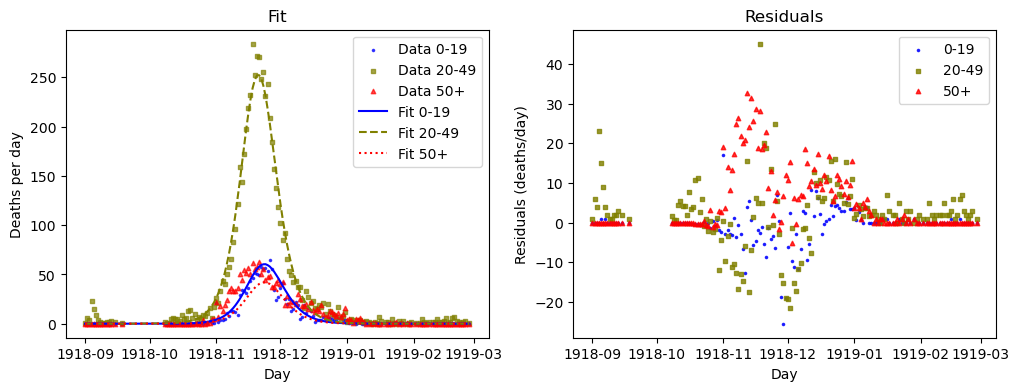

In [220]:
my_fit.plot_fit(['0-19','20-49','50+'], xplot=xplot)
#plt.savefig('Fit.pdf')